In [1]:
# !pip install seaborn catboost -q

import numpy as np
import pandas as pd

# Считываем данные

In [5]:
path = "../data/quickstart_train.csv"
data = pd.read_csv(path)
data.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,3.880920,1.651883e+07,0.1,172.793237,-5.029476,174,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,4.181149,1.398317e+07,0.1,203.462289,-14.260456,174,171


## EDA

In [10]:
data.shape

(2337, 17)

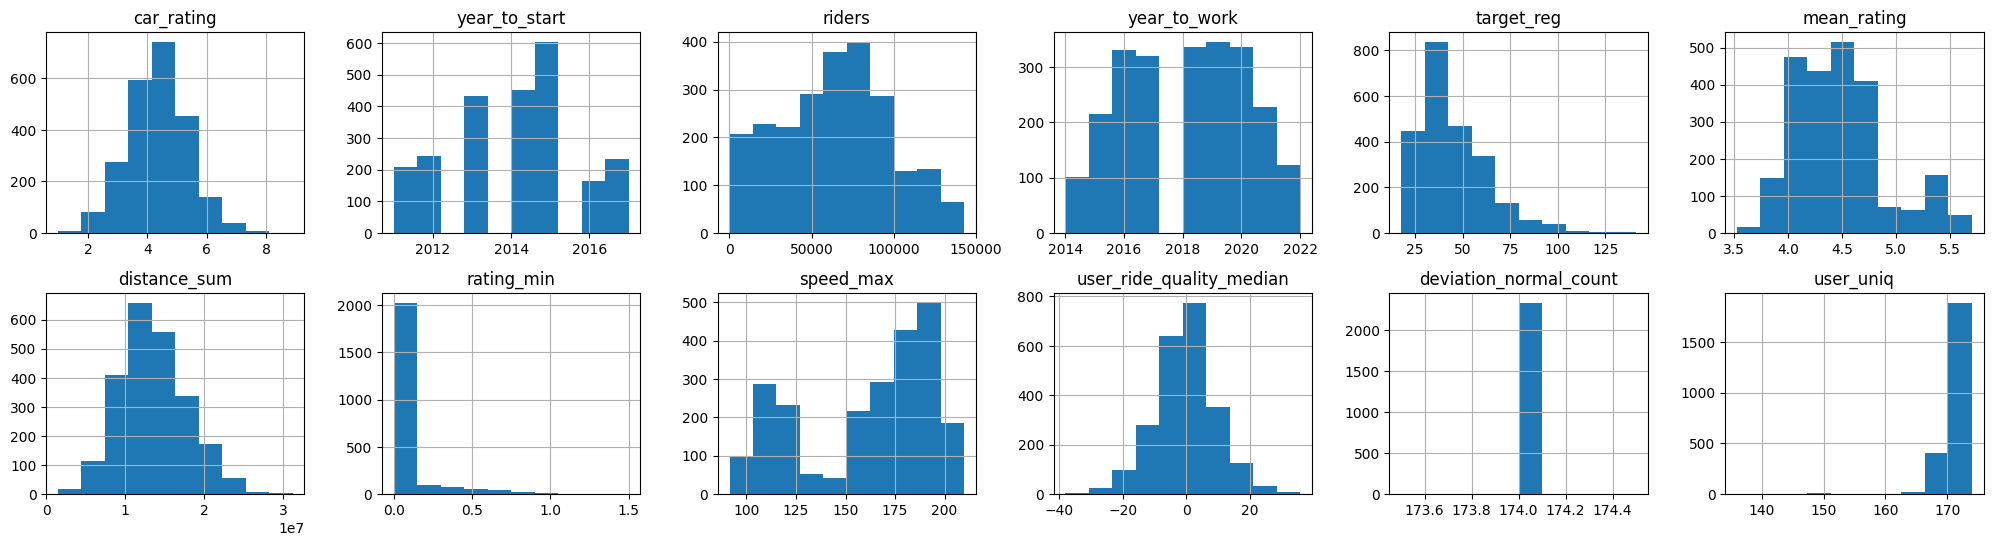

In [8]:
_ = data.hist(figsize=(25, 6), layout=(-1, 6))

In [9]:
data[['car_id', 'model', 'car_type', 'fuel_type']].nunique() 

car_id       2337
model          26
car_type        4
fuel_type       2
dtype: int64

In [14]:
data['model'].value_counts()[:10]

Hyundai Solaris    161
Smart ForFour      158
Renault Kaptur     154
Renault Sandero    152
VW Polo VI         152
Skoda Rapid        147
Kia Sportage       147
Nissan Qashqai     146
Kia Rio X          143
VW Polo            141
Name: model, dtype: int64

In [16]:
data['car_type'].value_counts()[:10]

economy     1536
standart     599
business     117
premium       85
Name: car_type, dtype: int64

In [17]:
data['fuel_type'].value_counts()[:10]

petrol     2289
electro      48
Name: fuel_type, dtype: int64

## Генерируем признаки

In [18]:
data.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,3.880920,1.651883e+07,0.1,172.793237,-5.029476,174,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,4.181149,1.398317e+07,0.1,203.462289,-14.260456,174,171


In [121]:
def build_features(data):
    # считаем базовые признаки
    data['sum_rating'] = data['mean_rating'] * data['riders']
    data['year_in_work'] = data['year_to_work'] - data['year_to_start']
    data['mean_distance'] = data['distance_sum'] / data['year_in_work']
    data['riders_per_year'] = data['riders'] / data['year_in_work']
    return data

In [52]:
data = build_features(data)

In [106]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(data, test_size=0.2, random_state=42)
df_train.shape, df_val.shape

((1869, 21), (468, 21))

In [107]:
# считаем распределние таргета по model, так как там слишком много уникальных значения
models_stat = df_train.groupby(['model', 'target_class'])['car_id'].count().reset_index()
models_stat = pd.pivot_table(models_stat, index='model', columns='target_class', values='car_id')
models_stat = models_stat.reset_index().fillna(0)
models_stat['sum_bugs'] = models_stat[models_stat.columns[1:]].sum(axis=1)
for el in models_stat.columns[1:-1]:
    models_stat[el] = models_stat[el] / models_stat['sum_bugs']
models_stat.head()

target_class,model,another_bug,break_bug,electro_bug,engine_check,engine_fuel,engine_ignition,engine_overheat,gear_stick,wheel_shake,sum_bugs
0,Audi A3,0.142857,0.142857,0.214286,0.142857,0.142857,0.071429,0.071429,0.071429,0.0,14.0
1,Audi A4,0.125000,0.187500,0.062500,0.187500,0.125000,0.125000,0.062500,0.125000,0.0,16.0
2,Audi Q3,0.157895,0.000000,0.315789,0.052632,0.210526,0.052632,0.105263,0.105263,0.0,19.0
3,BMW 320i,0.100000,0.100000,0.000000,0.400000,0.100000,0.100000,0.000000,0.200000,0.0,10.0
4,Fiat 500,0.000000,0.176471,0.058824,0.176471,0.000000,0.058824,0.235294,0.294118,0.0,17.0


In [108]:
# судя по валидации models_stat ухудшает работу модели
# df_train = df_train.merge(models_stat, on='model', how='left')
# df_val = df_val.merge(models_stat, on='model', how='left')
# df_train.head()

## Группируем признаки и отбираем категориальные

In [109]:
cat_features = ["model", "car_type", "fuel_type"]  # Выделяем категориальные признаки
targets = ["target_class", "target_reg"]
features2drop = ["car_id"]  # эти фичи будут удалены

# Отбираем итоговый набор признаков для использования моделью
filtered_features = [i for i in df_train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print("cat_features", cat_features)
print("num_features", len(num_features))
print("targets", targets)

for c in cat_features:  # Избавлеямся от NaN'ов
    train[c] = train[c].astype(str)

cat_features ['model', 'car_type', 'fuel_type']
num_features 15
targets ['target_class', 'target_reg']


## Обучаем модель

In [110]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.metrics import balanced_accuracy_score

In [111]:
from sklearn.model_selection import train_test_split

X_train = df_train[filtered_features]
y_train = df_train["target_class"]

X_val = df_val[filtered_features]
y_val = df_val["target_class"]

In [112]:
params_cat = {
    "n_estimators": 1500,
    "learning_rate": 0.03,
    "depth": 5,
    "use_best_model": True,
    "cat_features": cat_features,
    "text_features": [],
    # 'train_dir' : '/path/to/catboost/model',
    # "border_count": 64,
    "l2_leaf_reg": 1,
    "bagging_temperature": 2,
    # "rsm": 0.5,
    # "loss_function": "RMSE",  # Не определена для регресси
    # 'auto_class_weights' : 'Balanced', # Не опредлен для регресси
    "random_state": 42,
    # "custom_metric": ["MAE", "MAPE"],
}

cat_model = CatBoostClassifier(**params_cat)

In [113]:
cat_model.fit(
    X_train,
    y_train,
    verbose=100,
    eval_set=(X_val, y_val),
    early_stopping_rounds=150,
)

0:	learn: 2.0943674	test: 2.0981674	best: 2.0981674 (0)	total: 59.4ms	remaining: 1m 28s
100:	learn: 0.5870574	test: 0.6499162	best: 0.6499162 (100)	total: 1.07s	remaining: 14.8s
200:	learn: 0.4871647	test: 0.5948114	best: 0.5947466 (199)	total: 2.21s	remaining: 14.3s
300:	learn: 0.4215588	test: 0.5712324	best: 0.5712324 (300)	total: 3.19s	remaining: 12.7s
400:	learn: 0.3749516	test: 0.5597604	best: 0.5597604 (400)	total: 4.2s	remaining: 11.5s
500:	learn: 0.3401384	test: 0.5577355	best: 0.5577201 (499)	total: 5.19s	remaining: 10.3s
600:	learn: 0.3095613	test: 0.5573697	best: 0.5554476 (557)	total: 6.21s	remaining: 9.29s
700:	learn: 0.2836728	test: 0.5581361	best: 0.5554476 (557)	total: 7.28s	remaining: 8.3s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.555447647
bestIteration = 557

Shrink model to first 558 iterations.


In [114]:
pred = cat_model.predict(X_val)
balanced_accuracy_score(y_val, pred)

0.8164963966724327

## Смотрим на важности признаков

In [115]:
import shap

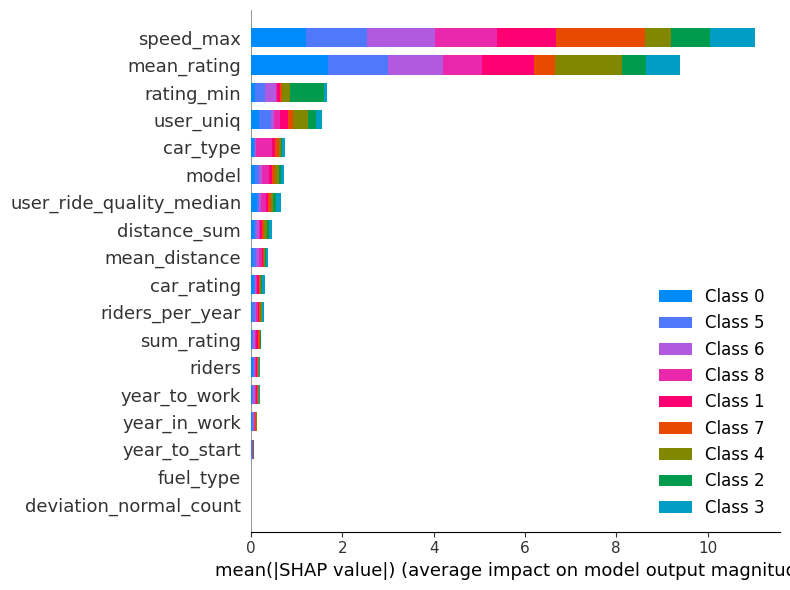

In [119]:
# Построим усредненный shap values 
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(Pool(X_train, y_train, cat_features=cat_features))

shap.summary_plot(shap_values, X_train, plot_size=0.25,)

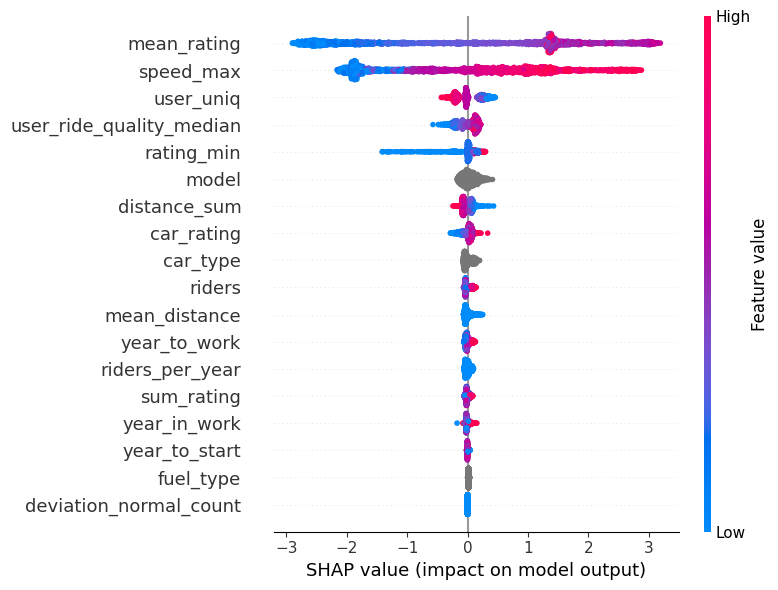

In [120]:
# построем shap values отдельно для нулевого класса
shap.summary_plot(shap_values[0], X_train, plot_size=0.25,)

## Делаем предсказания на тестовой выборке

In [122]:
df_test = pd.read_csv('../data/quickstart_test.csv')
df_test.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,P17494612l,Skoda Rapid,economy,petrol,4.80,2013,42269,2019,gear_stick,3.746207,1.407539e+07,0.10,195.454152,10.566220,174,170
1,N-1530212S,Renault Sandero,standart,petrol,4.32,2015,90014,2016,engine_overheat,4.318966,1.970390e+07,0.00,181.538685,11.807941,174,174
2,B-1154399t,Smart ForTwo,economy,petrol,4.46,2015,82684,2017,electro_bug,5.134655,9.314946e+06,0.10,118.440645,14.862538,174,172
3,F12725233R,Smart ForFour,economy,petrol,2.80,2014,68833,2021,engine_check,4.617356,9.336838e+06,0.83,112.829785,20.088904,174,172
4,l-1139189J,Skoda Rapid,economy,petrol,6.56,2013,42442,2021,another_bug,4.287471,1.196250e+07,0.00,187.846088,3.698460,174,172


In [123]:
df_test = build_features(df_test)
# df_test = df_test.merge(models_stat, on='model', how='left')
df_test.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq,sum_rating,year_in_work,mean_distance,riders_per_year
0,P17494612l,Skoda Rapid,economy,petrol,4.80,2013,42269,2019,gear_stick,3.746207,1.407539e+07,0.10,195.454152,10.566220,174,170,158348.419310,6,2.345899e+06,7044.833333
1,N-1530212S,Renault Sandero,standart,petrol,4.32,2015,90014,2016,engine_overheat,4.318966,1.970390e+07,0.00,181.538685,11.807941,174,174,388767.362069,1,1.970390e+07,90014.000000
2,B-1154399t,Smart ForTwo,economy,petrol,4.46,2015,82684,2017,electro_bug,5.134655,9.314946e+06,0.10,118.440645,14.862538,174,172,424553.828276,2,4.657473e+06,41342.000000
3,F12725233R,Smart ForFour,economy,petrol,2.80,2014,68833,2021,engine_check,4.617356,9.336838e+06,0.83,112.829785,20.088904,174,172,317826.487701,7,1.333834e+06,9833.285714
4,l-1139189J,Skoda Rapid,economy,petrol,6.56,2013,42442,2021,another_bug,4.287471,1.196250e+07,0.00,187.846088,3.698460,174,172,181968.855402,8,1.495312e+06,5305.250000


In [126]:
preds = cat_model.predict(df_test[filtered_features])
sub = pd.DataFrame({'bug_type': preds[:, 0]})
sub.to_csv('../data/solutions/baseline_sol.csv', index=False)
sub.head()

,bug_type
0,engine_overheat
1,electro_bug
2,break_bug
3,gear_stick
4,electro_bug
